# Optimization Techniques in Machine Learning

# **SmartFlow**

# Objective

The primary goal of this project is to develop a smart irrigation system that leverages machine learning to predict whether irrigation is required based on environmental and soil conditions. By analyzing key factors such as soil moisture, temperature, humidity, rainfall, and crop type, the system provides data-driven recommendations to optimize water usage in agriculture. This technology aims to address critical challenges faced by farmers, particularly in regions like South Sudan, where water scarcity and inefficient irrigation practices often lead to high production costs and low crop yields.

In [16]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# The Dataset

The dataset used for this project was obtained from Kaggle and combined with another dataset to meet the specific requirements of the project. It includes 8 key features and a target variable indicating whether irrigation is needed or not. Below is a brief description of the dataset:

Features:
Soil Moisture: Measures the water content in the soil (percentage).

Temperature: Records the ambient temperature (°C).

Time: Tracks the time of day (hours).

Wind Speed: Measures the speed of wind (Km/h).

Air Humidity: Measures the moisture level in the air (percentage).

Rainfall: Records the amount of precipitation (mm).

Soil Type: Categorizes the type of soil (e.g., sandy, loamy, clay).

Crop Type: Specifies the type of crop being grown (e.g., maize, wheat, vegetables).

Target Variable:
Irrigation Needed:

0: Irrigation Not Needed.

1: Irrigation Needed.

Dataset Characteristics:
Source: The dataset was initially obtained from Kaggle and combined with another dataset to enhance its relevance and completeness.

Preprocessing: The combined dataset was cleaned, normalized, and encoded (for categorical variables) to ensure compatibility with machine learning algorithms.

In [17]:
def load_and_align_datasets(primary_csv_path, secondary_csv_path):
    df1 = pd.read_csv(primary_csv_path)
    df2 = pd.read_csv(secondary_csv_path)

    repeats = len(df1) // len(df2) + 1
    df2_repeated = pd.concat([df2] * repeats, ignore_index=True).iloc[:len(df1)]

    df1.reset_index(drop=True, inplace=True)
    df2_repeated.reset_index(drop=True, inplace=True)

    return df1, df2_repeated
df1, df2_repeated = load_and_align_datasets('TARP.csv', 'smart_irrigation_dataset.csv')


In [18]:
def concatenate_selected_columns(df1, df2_repeated, columns_to_select):
    selected_columns = df2_repeated[columns_to_select]
    df3 = pd.concat([df1, selected_columns], axis=1)
    return df3
columns_to_select = ['Soil Type', 'Crop Type']
df3 = concatenate_selected_columns(df1, df2_repeated, columns_to_select)
#print(df3.head())
df3.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status,Soil Type,Crop Type
0,54,22,70,21,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON,Loamy,Soybean
1,12,20,40,104,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF,Clay,Soybean
2,34,26,35,62,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON,Loamy,Rice
3,7,44,44,93,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF,Loamy,Tomato
4,50,38,23,92,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF,Clay,Maize


In [4]:
#df2.head()

In [19]:
df3.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status,Soil Type,Crop Type
0,54,22,70,21,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON,Loamy,Soybean
1,12,20,40,104,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF,Clay,Soybean
2,34,26,35,62,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON,Loamy,Rice
3,7,44,44,93,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF,Loamy,Tomato
4,50,38,23,92,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF,Clay,Maize


In [20]:
#
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  int64  
 1   Temperature          100000 non-null  int64  
 2    Soil Humidity       100000 non-null  int64  
 3   Time                 100000 non-null  int64  
 4   Air temperature (C)  23995 non-null   float64
 5   Wind speed (Km/h)    23995 non-null   float64
 6   Air humidity (%)     23995 non-null   float64
 7   Wind gust (Km/h)     23995 non-null   float64
 8   Pressure (KPa)       23995 non-null   float64
 9   ph                   2200 non-null    float64
 10  rainfall             2200 non-null    float64
 11  N                    2200 non-null    float64
 12  P                    2200 non-null    float64
 13  K                    2200 non-null    float64
 14  Status               100000 non-null  object 
 15  Soil Type         

In [21]:
df3.columns

Index(['Soil Moisture', 'Temperature', ' Soil Humidity', 'Time',
       'Air temperature (C)', 'Wind speed (Km/h)', 'Air humidity (%)',
       'Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 'K',
       'Status', 'Soil Type', 'Crop Type'],
      dtype='object')

In [22]:
df3.shape

(100000, 17)

In [23]:
# remove redundant columns
columns_to_remove = [' Soil Humidity', 'Air temperature (C)', 'N', 'P', 'K','Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'Status']
df3.drop(columns=columns_to_remove, inplace=True)


In [24]:
#display the updated DataFrame
df3.head()

,Soil Moisture,Temperature,Time,Wind speed (Km/h),Air humidity (%),rainfall,Soil Type,Crop Type
0,54,22,21,2.13,55.04,202.935536,Loamy,Soybean
1,12,20,104,2.01,55.17,226.655537,Clay,Soybean
2,34,26,62,1.90,55.30,263.964248,Loamy,Rice
3,7,44,93,2.28,54.20,242.864034,Loamy,Tomato
4,50,38,92,2.66,53.09,262.717340,Clay,Maize


In [25]:
df3.describe()

,Soil Moisture,Temperature,Time,Wind speed (Km/h),Air humidity (%),rainfall
count,100000.000000,100000.000000,100000.000000,23995.000000,23995.000000,2200.000000
mean,45.484070,22.536100,55.253650,9.896898,58.521052,103.463655
std,25.993998,13.251352,32.093033,4.325666,30.073448,54.958389
min,1.000000,0.000000,0.000000,0.000000,0.590000,20.211267
25%,23.000000,11.000000,28.000000,6.830000,33.980000,64.551686
50%,45.000000,23.000000,55.000000,9.530000,61.310000,94.867624
75%,68.000000,34.000000,83.000000,12.460000,86.360000,124.267508
max,90.000000,45.000000,110.000000,31.360000,96.000000,298.560117


In [26]:
df3.isnull().sum()

,0
Soil Moisture,0
Temperature,0
Time,0
Wind speed (Km/h),76005
Air humidity (%),76005
rainfall,97800
Soil Type,0
Crop Type,0


In [27]:
df3.shape

(100000, 8)

In [28]:
print(df3.columns)


Index(['Soil Moisture', 'Temperature', 'Time', 'Wind speed (Km/h)',
       'Air humidity (%)', 'rainfall', 'Soil Type', 'Crop Type'],
      dtype='object')


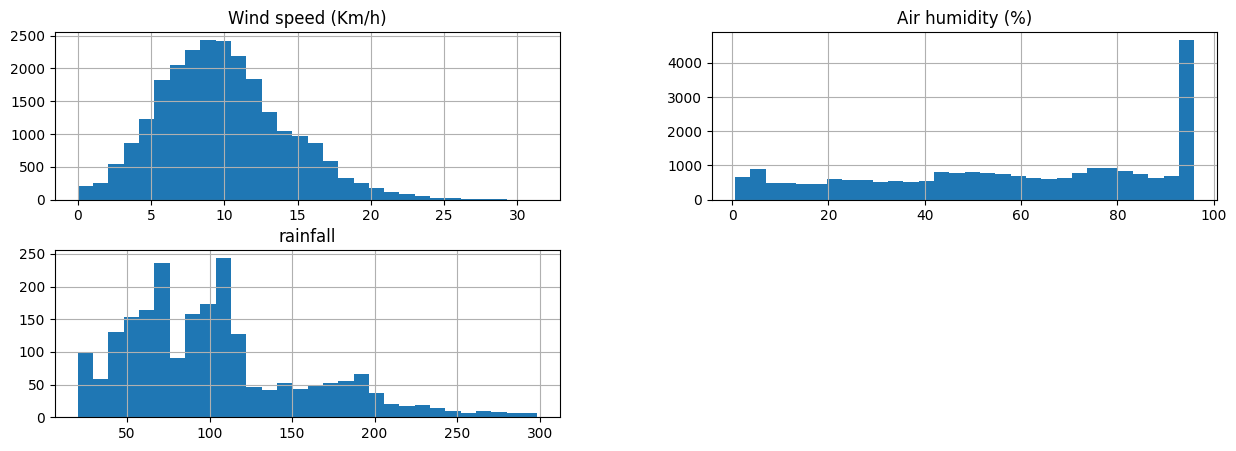

In [29]:
df3[['Wind speed (Km/h)', 'Air humidity (%)', 'rainfall']].hist(bins=30, figsize=(15, 5))
plt.show()


In [30]:
df3['Wind speed (Km/h)'].fillna(df3['Wind speed (Km/h)'].median(), inplace=True)
df3['Air humidity (%)'].fillna(df3['Air humidity (%)'].median(), inplace=True)
df3['rainfall'].fillna(df3['rainfall'].median(), inplace=True)

In [31]:
# convert categorical features to numerical features
df3['Soil Type'] = pd.Categorical(df3['Soil Type']).codes
df3['Crop Type'] = pd.Categorical(df3['Crop Type']).codes

print(df3)

       Soil Moisture  Temperature  Time  Wind speed (Km/h)  Air humidity (%)  \
0                 54           22    21               2.13             55.04   
1                 12           20   104               2.01             55.17   
2                 34           26    62               1.90             55.30   
3                  7           44    93               2.28             54.20   
4                 50           38    92               2.66             53.09   
...              ...          ...   ...                ...               ...   
99995             74            3    83               9.53             61.31   
99996             58           10    82               9.53             61.31   
99997              4           35    17               9.53             61.31   
99998             83           36    15               9.53             61.31   
99999             43           45    33               9.53             61.31   

         rainfall  Soil Type  Crop Type

In [32]:
df3.head()

,Soil Moisture,Temperature,Time,Wind speed (Km/h),Air humidity (%),rainfall,Soil Type,Crop Type
0,54,22,21,2.13,55.04,202.935536,1,2
1,12,20,104,2.01,55.17,226.655537,0,2
2,34,26,62,1.90,55.30,263.964248,1,1
3,7,44,93,2.28,54.20,242.864034,1,3
4,50,38,92,2.66,53.09,262.717340,0,0


In [33]:
# Define multi-threshold rules
def determine_irrigation(row):
    if row['Soil Moisture'] < 12 and row['Temperature'] > 35:
        return 1  # Irrigation needed (high temp and low soil moisture)
    elif row['Soil Moisture'] < 15 and row['Temperature'] > 25 and row['Crop Type'] in ['Rice', 'Tomato']:
        return 1  # Irrigation needed for water-intensive crops in warm conditions
    elif row['Soil Moisture'] < 40 and row['Temperature'] > 20:
        return 1  # Irrigation needed for moderate conditions
    else:
        return 0  # Irrigation not needed

# Apply the rules to create the target variable
df3['Irrigation_Needed'] = df3.apply(determine_irrigation, axis=1)

print(df3)

       Soil Moisture  Temperature  Time  Wind speed (Km/h)  Air humidity (%)  \
0                 54           22    21               2.13             55.04   
1                 12           20   104               2.01             55.17   
2                 34           26    62               1.90             55.30   
3                  7           44    93               2.28             54.20   
4                 50           38    92               2.66             53.09   
...              ...          ...   ...                ...               ...   
99995             74            3    83               9.53             61.31   
99996             58           10    82               9.53             61.31   
99997              4           35    17               9.53             61.31   
99998             83           36    15               9.53             61.31   
99999             43           45    33               9.53             61.31   

         rainfall  Soil Type  Crop Type

In [34]:
#print(df3['Irrigation_Needed'].value_counts())
#print(df3['Irrigation_Needed'].value_counts(normalize=True))  # Gives percentage


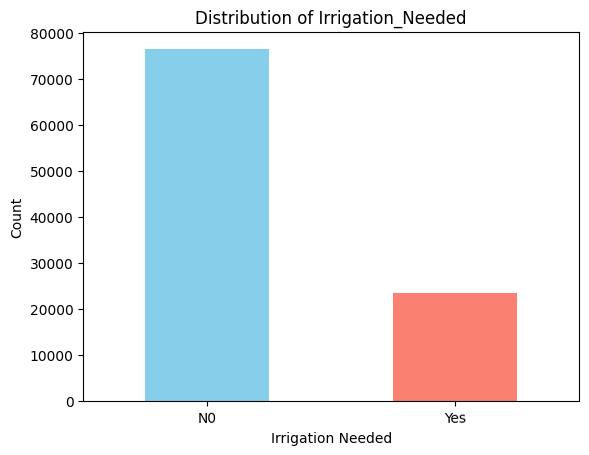

In [35]:
import matplotlib.pyplot as plt

# Plot the class distribution
df3['Irrigation_Needed'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Irrigation_Needed')
plt.xlabel('Irrigation Needed')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['N0', 'Yes'], rotation=1)
plt.show()


In [36]:
# Verify how many "YES" cases actually exist
print(df3['Irrigation_Needed'].value_counts())

# If less than 50 "YES" cases, machine learning is impossible

Irrigation_Needed
0    76422
1    23578
Name: count, dtype: int64


In [37]:
# check missinng values
df3.isnull().sum()

,0
Soil Moisture,0
Temperature,0
Time,0
Wind speed (Km/h),0
Air humidity (%),0
rainfall,0
Soil Type,0
Crop Type,0
Irrigation_Needed,0


In [38]:
df3.shape

(100000, 9)

In [39]:
df3.columns

Index(['Soil Moisture', 'Temperature', 'Time', 'Wind speed (Km/h)',
       'Air humidity (%)', 'rainfall', 'Soil Type', 'Crop Type',
       'Irrigation_Needed'],
      dtype='object')

In [40]:
# duplicate record
duplicates = df3[df3.duplicated()]
print(duplicates)

       Soil Moisture  Temperature  Time  Wind speed (Km/h)  Air humidity (%)  \
26909             60            8    21               9.53             61.31   
29366             66           22    30               9.53             61.31   
31764             61           44   109               9.53             61.31   
33268             27           20    82               9.53             61.31   
34650             28           30    67               9.53             61.31   
...              ...          ...   ...                ...               ...   
99795             27           10    90               9.53             61.31   
99866             15           16     5               9.53             61.31   
99871             11            7    26               9.53             61.31   
99888             40           43     7               9.53             61.31   
99930             32           22    62               9.53             61.31   

        rainfall  Soil Type  Crop Type 

In [41]:
# Remove duplicates in-place
df3.drop_duplicates(inplace=True)

In [42]:
df3.shape

(99704, 9)

In [43]:
df3.describe()

,Soil Moisture,Temperature,Time,Wind speed (Km/h),Air humidity (%),rainfall,Soil Type,Crop Type,Irrigation_Needed
count,99704.000000,99704.000000,99704.000000,99704.000000,99704.000000,99704.000000,99704.000000,99704.000000,99704.000000
mean,45.487102,22.538474,55.248947,9.618298,60.638805,95.057298,1.422220,1.977092,0.235868
std,25.995192,13.251876,32.089899,2.127812,14.801099,8.259024,1.124234,1.431910,0.424542
min,1.000000,0.000000,0.000000,0.000000,0.590000,20.211267,0.000000,0.000000,0.000000
25%,23.000000,11.000000,28.000000,9.530000,61.310000,94.867624,0.000000,1.000000,0.000000
50%,45.000000,23.000000,55.000000,9.530000,61.310000,94.867624,1.000000,2.000000,0.000000
75%,68.000000,34.000000,83.000000,9.530000,61.310000,94.867624,2.000000,3.000000,0.000000
max,90.000000,45.000000,110.000000,31.360000,96.000000,298.560117,3.000000,4.000000,1.000000


In [44]:
# correlation
df3.corr()

,Soil Moisture,Temperature,Time,Wind speed (Km/h),Air humidity (%),rainfall,Soil Type,Crop Type,Irrigation_Needed
Soil Moisture,1.000000,0.003696,-0.001983,-0.005095,0.002575,-0.009966,0.002264,-0.001346,-0.542616
Temperature,0.003696,1.000000,0.004580,-0.005375,-0.003686,-0.001168,-0.003983,-0.007741,0.438010
Time,-0.001983,0.004580,1.000000,-0.001968,0.000903,0.004972,0.000084,-0.001046,0.002595
Wind speed (Km/h),-0.005095,-0.005375,-0.001968,1.000000,-0.270930,-0.001021,0.002872,-0.000964,0.003187
Air humidity (%),0.002575,-0.003686,0.000903,-0.270930,1.000000,-0.058798,-0.001595,0.001454,-0.005414
rainfall,-0.009966,-0.001168,0.004972,-0.001021,-0.058798,1.000000,-0.002747,-0.005563,0.003587
Soil Type,0.002264,-0.003983,0.000084,0.002872,-0.001595,-0.002747,1.000000,0.018301,-0.006122
Crop Type,-0.001346,-0.007741,-0.001046,-0.000964,0.001454,-0.005563,0.018301,1.000000,-0.002776
Irrigation_Needed,-0.542616,0.438010,0.002595,0.003187,-0.005414,0.003587,-0.006122,-0.002776,1.000000


In [45]:
# save df3 as a csv file
df3.to_csv('df3.csv', index=False)


In [46]:
df3.rename(columns={
    "Soil Moisture": "Soil_Moisture",
    "Temperature": "temperature",
    "Wind speed (Km/h)": "Wind_speed_km_h",
    "Air humidity (%)": "Air_humidity_percent",
    "Soil Type": "Soil_Type",
    "Crop Type": "Crop_Type"
}, inplace=True)

# Save the corrected file
df3.to_csv("data.csv", index=False)


In [47]:
# save df3 as a csv file
df3.to_csv('data.csv', index=False)

In [ ]:
from google.colab import files
files.download('data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: >

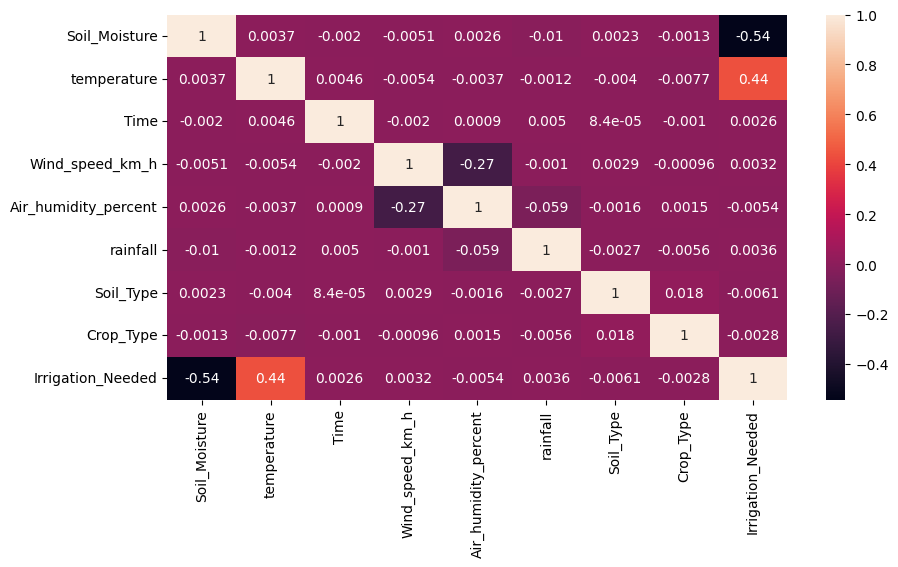

In [ ]:
#plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.heatmap(df3.corr(), annot=True)

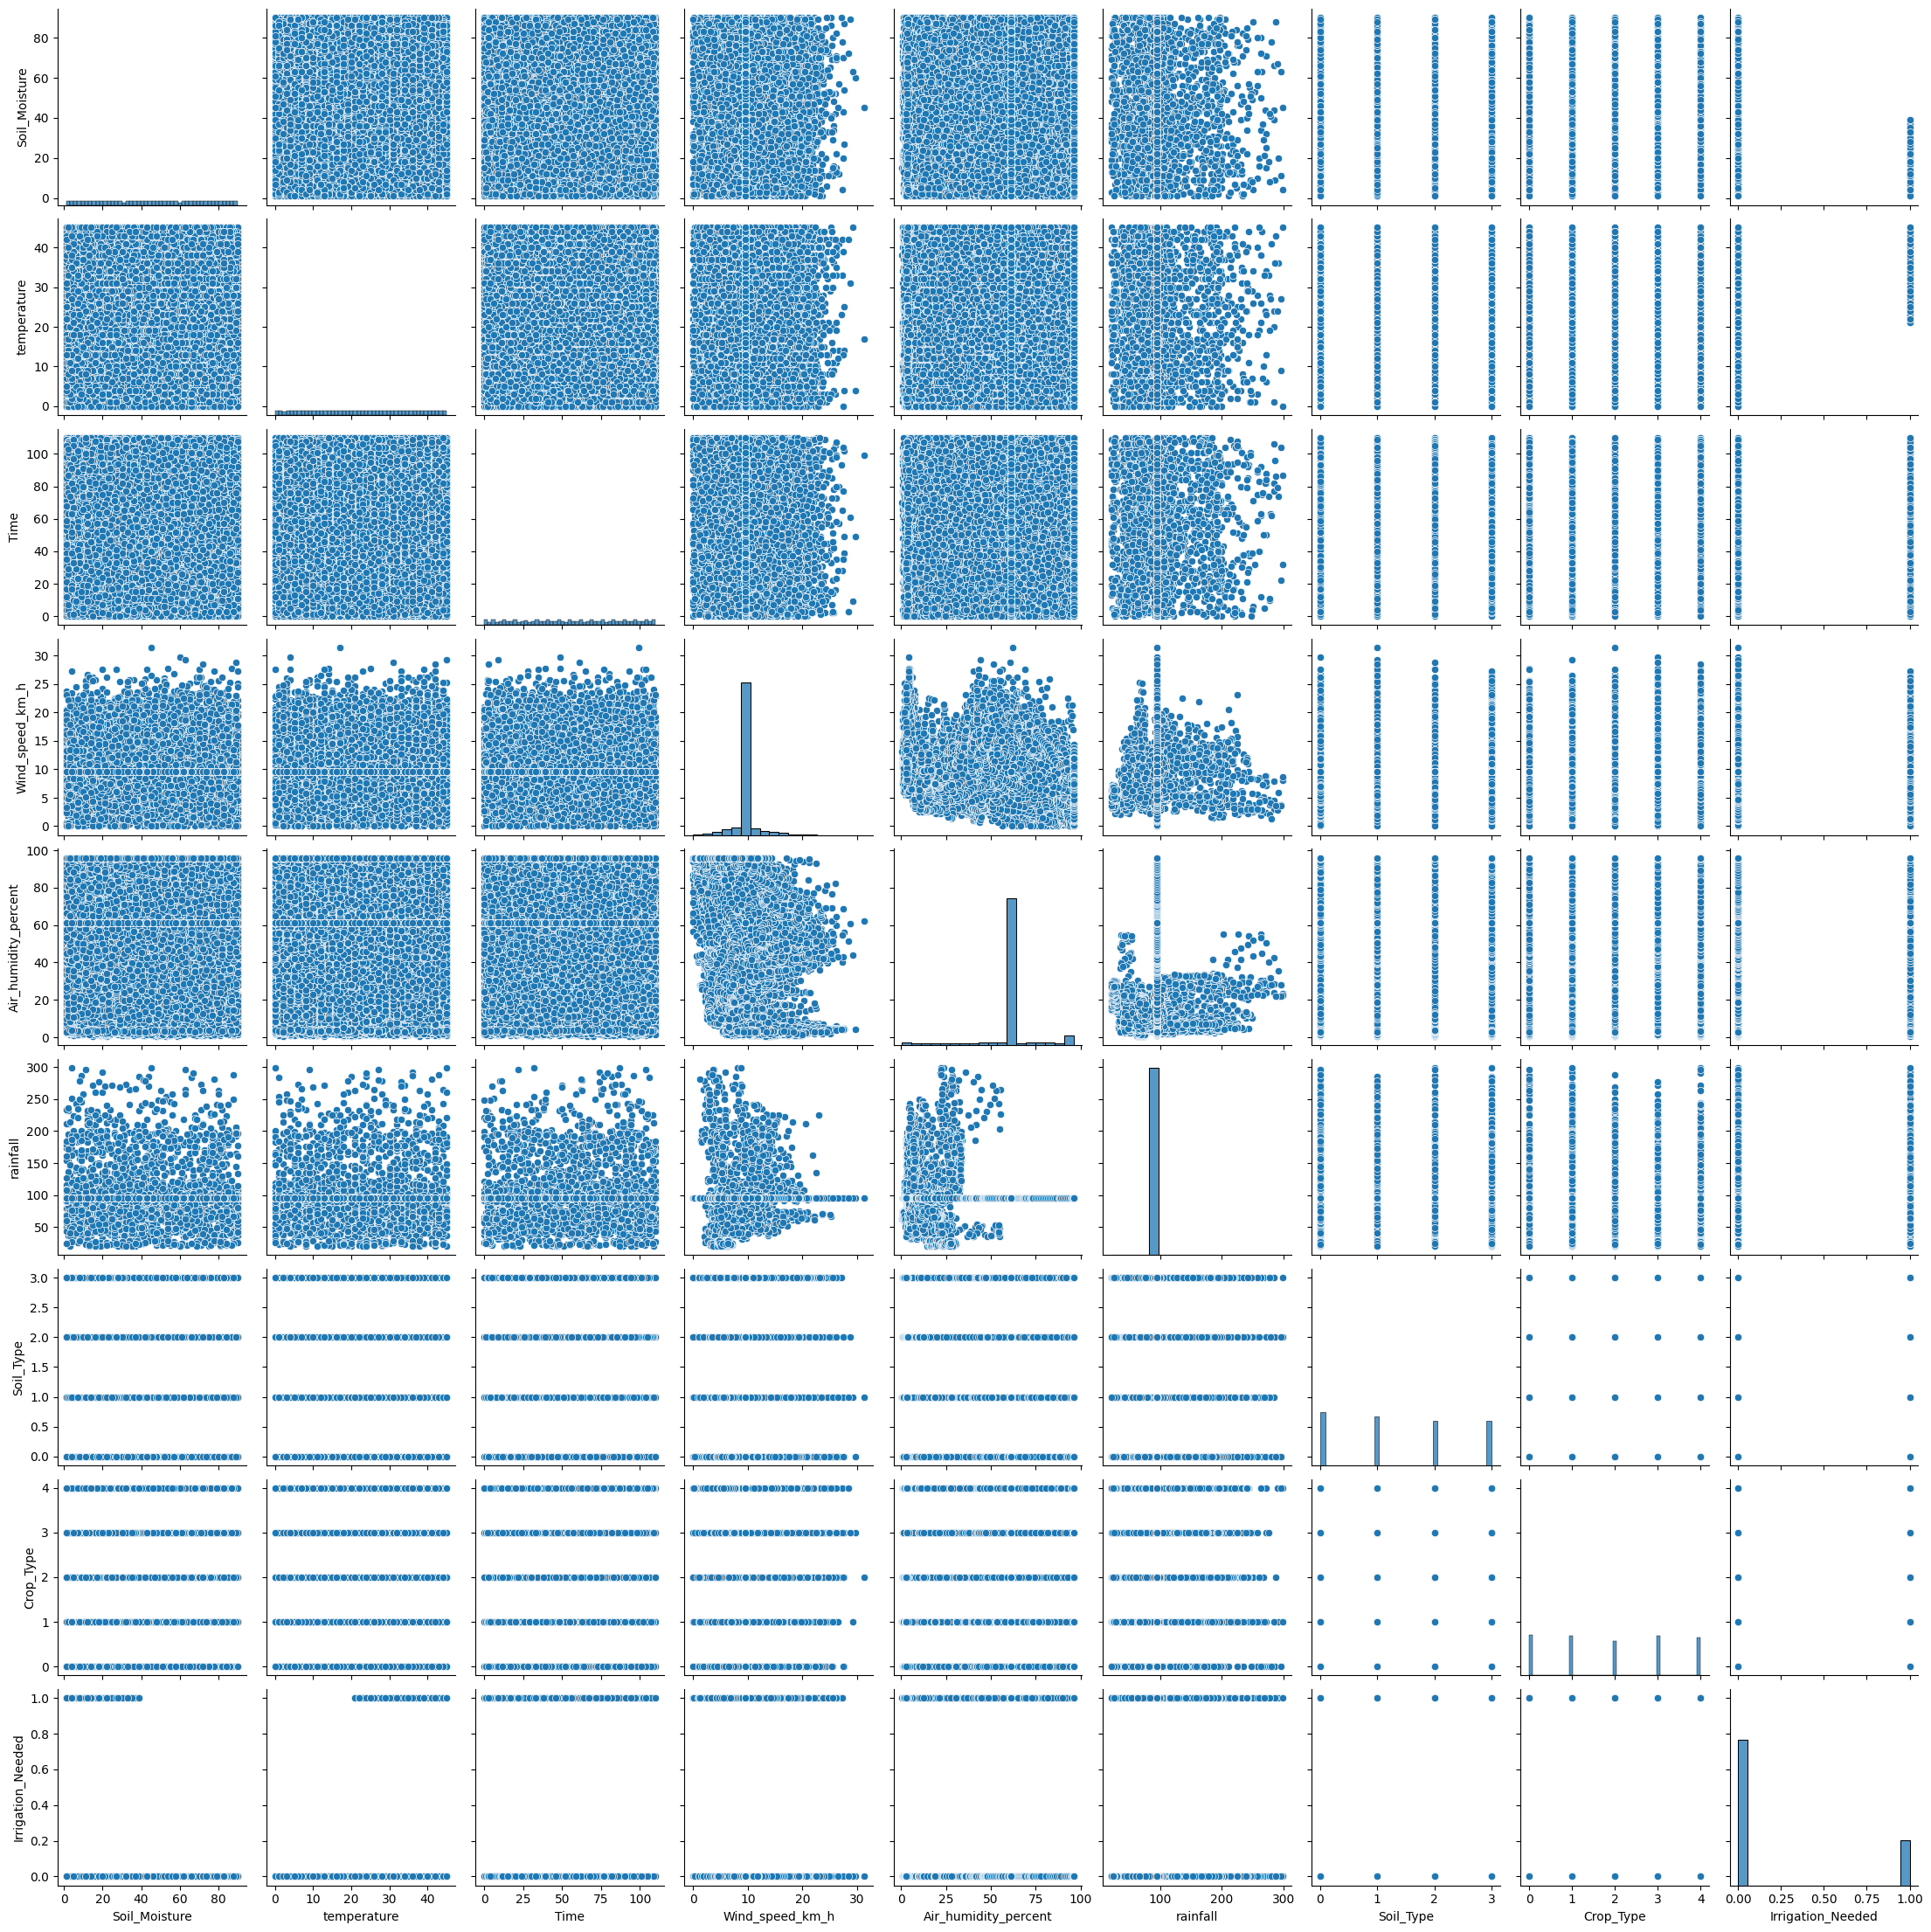

In [48]:
# univariate, bivariate, multivariate analysis
sns.pairplot(df3)

In [ ]:
#pip install imbalanced-learn


In [49]:
# dependent and independent variable
X = df3.drop('Irrigation_Needed', axis=1)
y = df3['Irrigation_Needed']

In [50]:

# split the data into training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3)
scaled_df3 = pd.DataFrame(scaled_data,
                         columns=df3.columns)
print(scaled_df3.head())

   Soil_Moisture  temperature      Time  Wind_speed_km_h  \
0       0.327481    -0.040634 -1.067287        -3.519265   
1      -1.288210    -0.191557  1.519210        -3.575662   
2      -0.441896     0.261212  0.210380        -3.627358   
3      -1.480554     1.619517  1.176421        -3.448770   
4       0.173606     1.166748  1.145259        -3.270182   

   Air_humidity_percent   rainfall  Soil_Type  Crop_Type  Irrigation_Needed  
0             -0.378271  13.061929  -0.375564   0.015998          -0.555585  
1             -0.369488  15.933954  -1.265063   0.015998          -0.555585  
2             -0.360705  20.451303  -0.375564  -0.682373           1.799905  
3             -0.435024  17.896483  -0.375564   0.714370           1.799905  
4             -0.510019  20.300327  -1.265063  -1.380745          -0.555585  


In [ ]:
#print(y_test.value_counts())  # See if the test set is also imbalanced


In [ ]:
X_train

,Soil_Moisture,temperature,Time,Wind_speed_km_h,Air_humidity_percent,rainfall,Soil_Type,Crop_Type
37282,40,20,22,9.53,61.31,94.867624,0,4
71611,32,3,77,9.53,61.31,94.867624,2,3
407,17,10,88,13.26,8.27,198.829881,0,1
49654,2,0,59,9.53,61.31,94.867624,2,3
63482,17,41,90,9.53,61.31,94.867624,3,2
...,...,...,...,...,...,...,...,...
6265,28,8,103,11.52,35.16,94.867624,2,2
54935,25,35,55,9.53,61.31,94.867624,1,2
76946,55,3,31,9.53,61.31,94.867624,0,0
860,22,28,35,3.12,52.26,53.409060,2,1


In [60]:
y

,Irrigation_Needed
0,0
1,0
2,1
3,1
4,0
...,...
99995,0
99996,0
99997,1
99998,0


In [61]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", Counter(y_train_resampled))


Class distribution after SMOTE: Counter({0: 60956, 1: 60956})


In [62]:
from collections import Counter

print("Test set class distribution:", Counter(y_test))


Test set class distribution: Counter({0: 15231, 1: 4710})


# Neural network model

# Model Architecture:

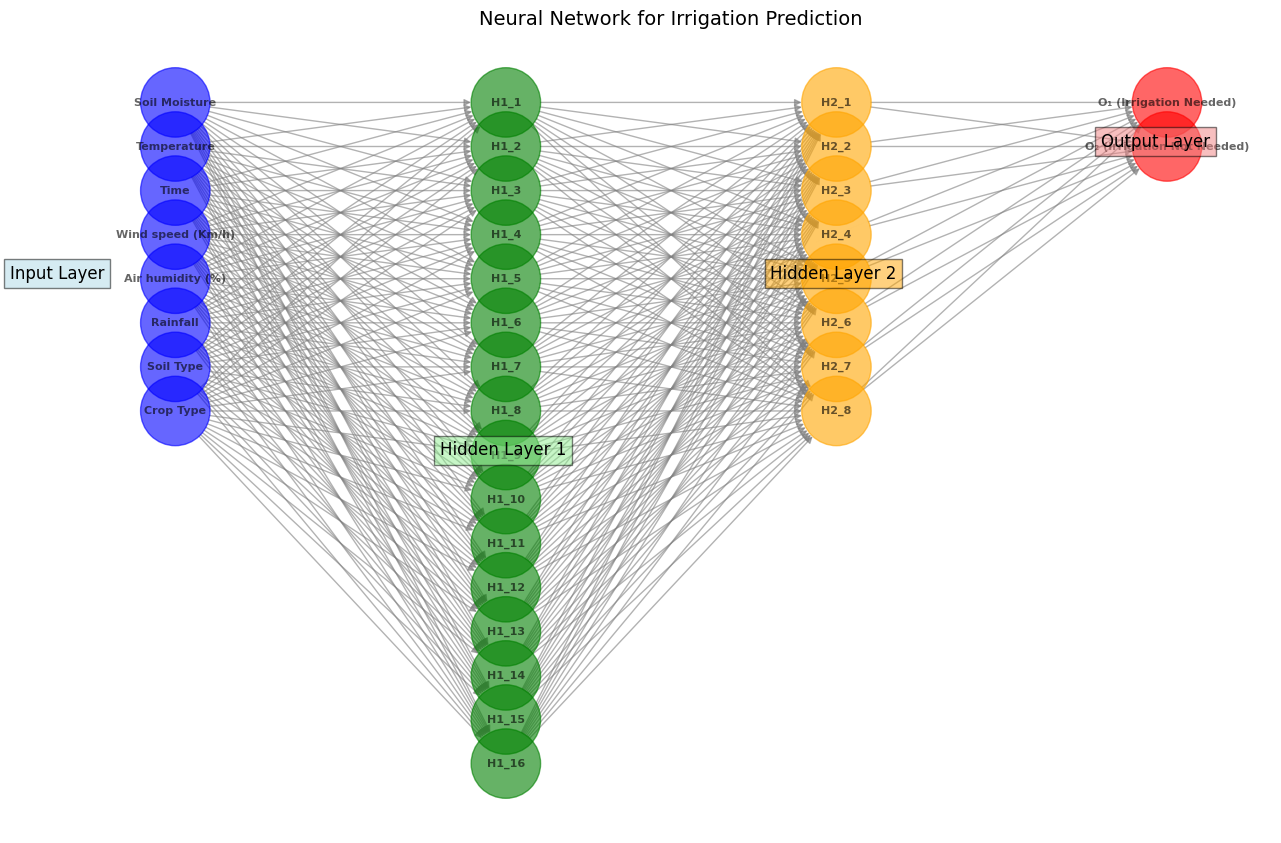

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop


def define_model(early_stopping: bool, dropout: float, learning_rate: float, num_features: int, optimization: str = "adam", regularization: float = 0.01, reg_strength: float = 0.01):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(num_features,)))

    # Hidden Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))

    # Output Layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizers_dict = {
        "adam": Adam(learning_rate=learning_rate),
        "sgd": SGD(learning_rate=learning_rate),
        "rmsprop": RMSprop(learning_rate=learning_rate)
    }
    optimizer = optimizers_dict.get(optimization.lower(), Adam(learning_rate=learning_rate))

    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping Callback (if enabled)
    callback_list = [EarlyStopping(monitor='val_loss', patience=5)] if early_stopping else []

    return model, callback_list

# Now your model should run without errors
num_features = X_train.shape[1]  # Ensure this is defined
#class_weights = {0: 1, 1: 25}


model, callbacks = define_model(early_stopping=True,
    dropout=0.5,
    learning_rate=0.001,
    num_features=num_features,
    optimization="adam",
    reg_strength=0.01
                                ) # Now passing a float value
history = model.fit(X_train_resampled, y_train_resampled,
          validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=callbacks)


Epoch 1/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8311 - loss: 0.9384 - val_accuracy: 0.9816 - val_loss: 0.1016
Epoch 2/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9723 - loss: 0.1227 - val_accuracy: 0.9872 - val_loss: 0.0702
Epoch 3/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9767 - loss: 0.1033 - val_accuracy: 0.9888 - val_loss: 0.0662
Epoch 4/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9769 - loss: 0.1011 - val_accuracy: 0.9863 - val_loss: 0.0737
Epoch 5/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9781 - loss: 0.0969 - val_accuracy: 0.9823 - val_loss: 0.0783
Epoch 6/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9772 - loss: 0.0971 - val_accuracy: 0.9883 - val_loss: 0.0648
Epoch 7/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9762 - loss: 0.0990 - val_accuracy: 0.9876 - val_loss: 0.0615
Epoch 8/50
3810/3810 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9764 - loss: 0

In [ ]:
#num_features = X_train.shape[1]  # Dynamically determine the number of features

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def loss_curve_plot(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

# validation acurracy
def accuracy_curve_plot(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

def print_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, np.round(y_pred))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    #print("Classification Report:\n", classification_report(y_test, np.round(y_pred)))
    # Calculate accuracy, precision, recall, F1 score
    accuracy = accuracy_score(y_test, np.round(y_pred))
    precision = precision_score(y_test, np.round(y_pred))
    recall = recall_score(y_test, np.round(y_pred))
    f1 = f1_score(y_test, np.round(y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

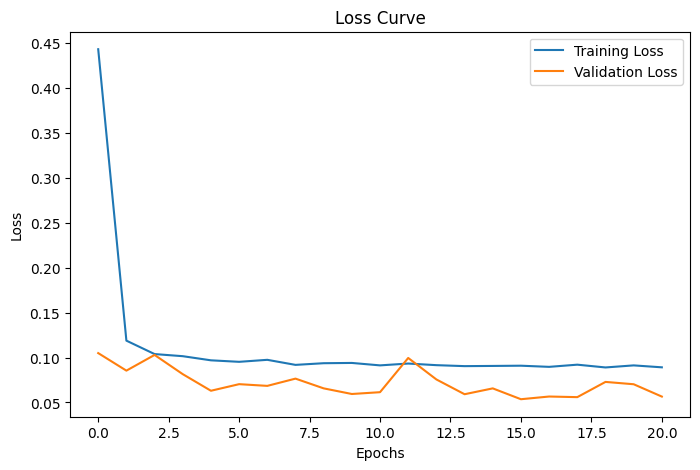

624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step


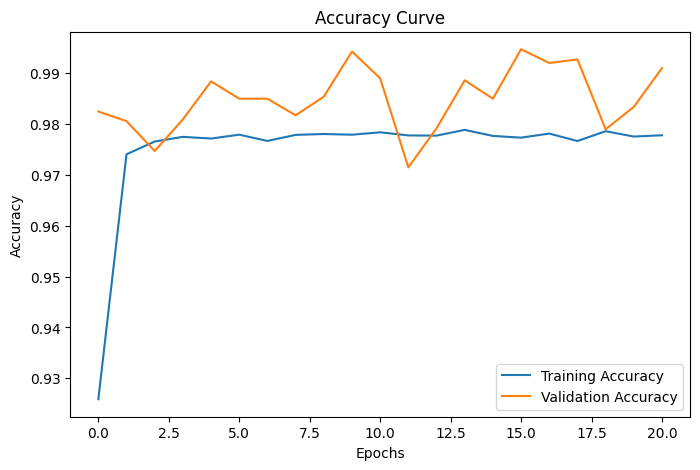

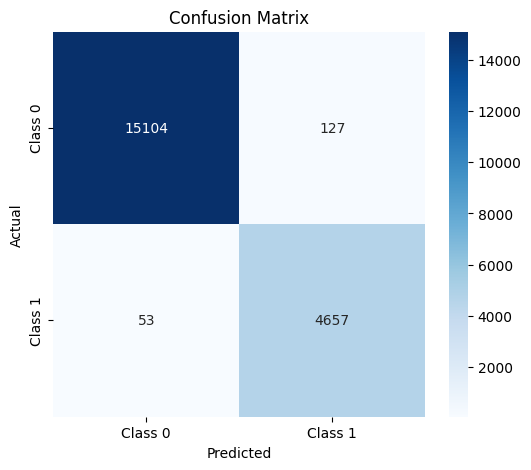

Accuracy: 0.9910
Precision: 0.9735
Recall: 0.9887
F1 Score: 0.9810


In [ ]:
# Model 2 - SGD optimizer with early stopping , dropout and learning rate of 0.01
#from tensorflow.keras.regularizers import l2
#model, callbacks = define_model(True, 0.3, 0.01, num_features, "sgd")
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks=callbacks)
loss_curve_plot(history)
accuracy_curve_plot(history)
y_pred = model.predict(X_test)
print_confusion_matrix(y_test, y_pred)


# Loss curve

The training loss drops sharply in the first few epochs and then gradually stabilizes at a low value, indicating effective model learning.
 The low loss values indicate that the model is learning well without major signs of overfitting.

# Accurancy

 The training accuracy increases rapidly in the first few epochs and then stabilizes around 97.5%-98%.
The fluctuations in validation accuracy suggest some variance in generalization performance.

# confusion matrix

This is a confusion matrix representing the classification performance of my model. Class 0 (Negative Class):
True Negatives (TN): 15,104 instances were correctly classified as Class 0.
                                        
False Positives (FP): 127 instances were incorrectly classified as Class 1.
                                        
Class 1 (Positive Class):
                                        
False Negatives (FN): 53 instances were incorrectly classified as Class 0.
                                        
True Positives (TP): 4,657 instances were correctly classified as Class 1.
#        Interpretation:
The model performs well, with a high number of correct classifications (both TN and TP).

The false positive (127) and false negative (53) values are relatively low, indicating strong precision and recall.
                                        
The model likely has a high accuracy and F1-score, as misclassification rates are minimal.
                                

In [65]:
 #Predictions
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = (model.predict(X_test) > 0.3).astype(int)
# ROC-AUC
print(f'ROC-AUC Score: {roc_auc_score(y_test, model.predict(X_test))}')

624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC-AUC Score: 0.9993294489211507


In [66]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,565 (135.02 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,044 (90.02 KB)

In [67]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.3).astype(int)  # Convert probabilities to binary classes

# Print sample predictions
print(y_pred_classes[:10])

624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]]


In [68]:
print("Probabilities for first 10 samples:\n", y_pred[:10])

Probabilities for first 10 samples:
 [[3.1005315e-05]
 [1.3042911e-02]
 [9.9203199e-01]
 [1.4849089e-03]
 [1.8467904e-03]
 [7.0189655e-01]
 [7.7977011e-06]
 [3.4251971e-05]
 [3.5433788e-04]
 [1.1207049e-03]]


In [69]:
# save the model
model.save('cool_model.h5')


In [70]:
from tensorflow.keras.models import load_model

model = load_model('cool_model.h5')  # Load the saved model
